# Traffic Balancer

This notebook is used to implement loss minimization techniques for traffic balancing in a network.

- Implement a traffic balancer that minimizes the loss in a network, given a loss function.
- Implement Lagrange multipliers in a linear system of equations that represents a gradient.
- Implement constraints

## Graph Importing

In [1]:
#the graph is stored as a pickle file, in a file called 'graph.gpickle'
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from collections import deque
import seaborn as sns
from tqdm import tqdm
import pickle

In [2]:
#read the graph from the file
#each code is a differeent graph with different starting conditions
# 1 - random graph
# 2 - linearly flow balanced graph
code = 1
with open('graph' + str(code) + '.gpickle', 'rb') as f:
    G = pickle.load(f)

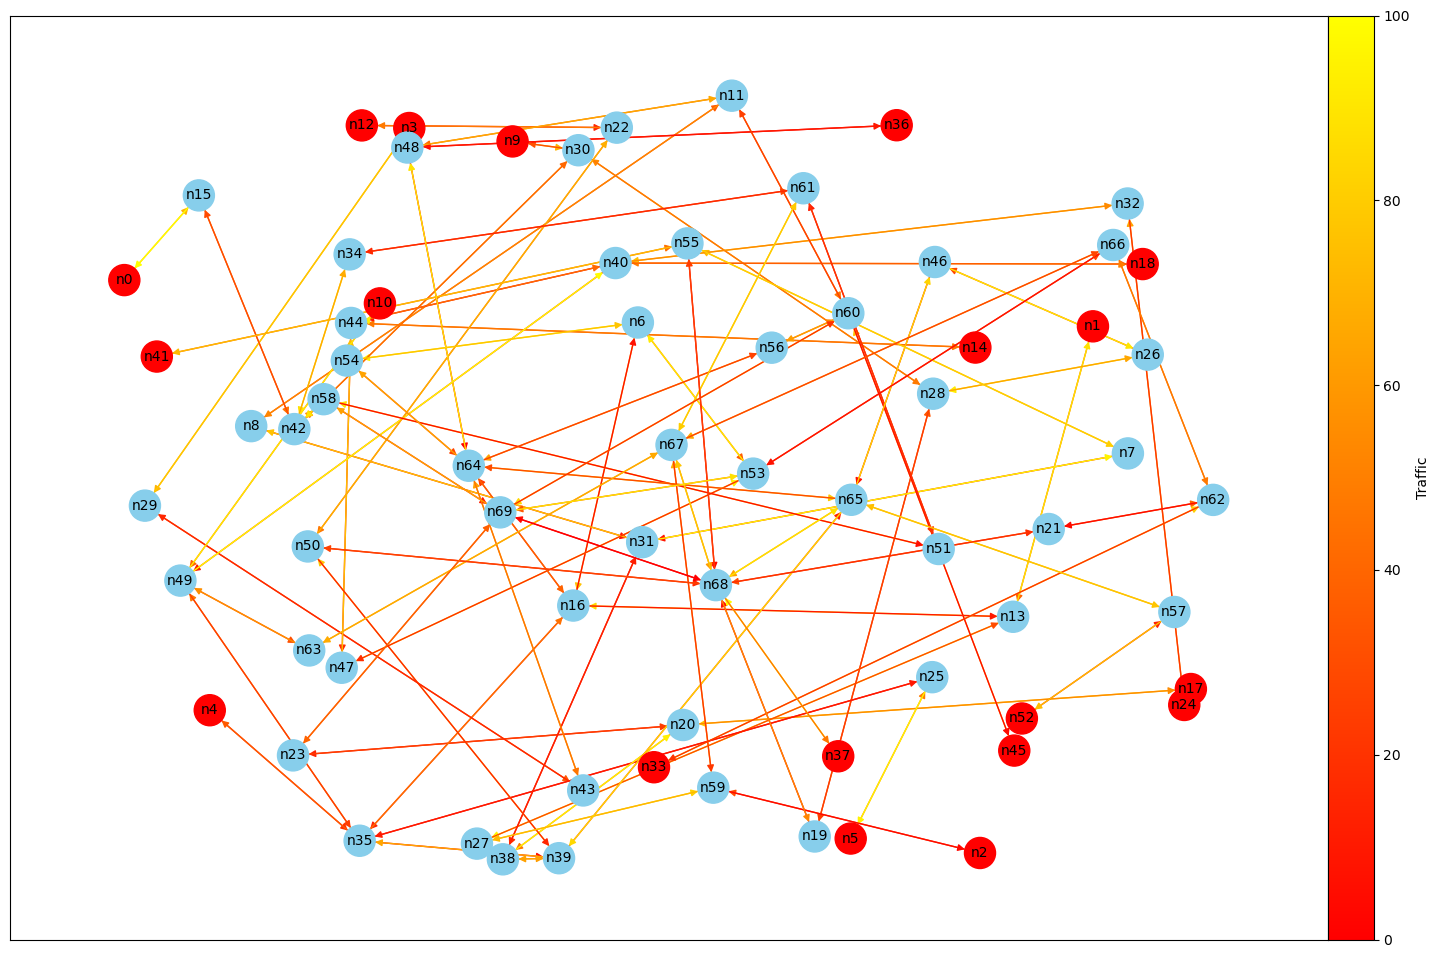

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Assuming you have already defined G and pos

# Draw the graph
plt.figure(figsize=(20, 12))
# Create a colormap that is the second half of the copper colormap

pos = nx.spring_layout(G, k=0.5, iterations=20)
cmap = plt.cm.autumn
# Draw the network with node colors and edge colors
nx.draw_networkx(G, with_labels=True, node_size=500, font_size=10, node_color=np.where(list(nx.get_node_attributes(G, 'border').values()), 'r', 'skyblue'), edge_color=[G.edges[edge]['traffic'] for edge in G.edges], edge_cmap=cmap, pos=pos)

# Get the current Axes instance
ax = plt.gca()

# Create a ScalarMappable to map numerical values to colors in the colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min([G.edges[edge]['traffic'] for edge in G.edges]), vmax=max([G.edges[edge]['traffic'] for edge in G.edges])))

# Empty array to hold the values for the color bar
sm.set_array([])

# Add the color bar at the bottom of the plot
plt.colorbar(sm, ax=ax, label='Traffic', pad=-0, orientation='vertical')

# Show the plot
plt.show()


## Loss Functions

- We have 4 kinds of loss functions, and each are applied at different scales, and differ on what they are applied to.
    - Node Loss Function: The loss function for a single node
    - Global Node Loss Function: The loss function for the entire network
    - Edge Loss Function: The loss function for a single edge
    - Global Edge Loss Function: The loss function for the entire network
- Node Loss Functions are applied to a single node:
- Edge Loss Functions are applied to a single edge, and really only have one type of structure:
  - Two-Way Traffic Disparity: This loss functions represents the fact that ideally, edges have equal traffic in both directions.
- Global Node Loss Functions are applied to the entire network, and are weighted by total traffic at a node to make larger nodes more important.
- Global Edge Loss Functions are applied to the entire network, and are weighted by total traffic on an edge to make larger edges more important.

In [4]:
#Lets define our node loss function
#Loss can be measured as the standard deviation of the traffic values flowing out of the node, into the node, or both
#we will define the function with a parameter 'direction' which can be 'in', 'out', or 'both'
def nodeLoss(G,node, direction):
    #if an edge has 4 lanes, then it needs to repeat the traffic value 4 times when calculating the standard deviation
    #so we will create a list of traffic values for each edge, and then flatten the list
    if direction == 'in':
        traffic = [G.edges[edge]['traffic'] for edge in G.in_edges(node) for i in range(G.edges[edge]['lanes'])]
    elif direction == 'out':
        traffic = [G.edges[edge]['traffic'] for edge in G.out_edges(node) for i in range(G.edges[edge]['lanes'])]
    elif direction == 'both':
        traffic = [G.edges[edge]['traffic'] for edge in G.in_edges(node) for i in range(G.edges[edge]['lanes'])] + [G.edges[edge]['traffic'] for edge in G.out_edges(node) for i in range(G.edges[edge]['lanes'])]
    else:
        raise ValueError('direction must be in, out, or both')
    #return both the standard deviation and the total traffic
    return np.std(traffic)

In [5]:

#Lets define our edge loss function
#Loss can be measured as the absolute difference between the traffic values flowing out of the edge and the traffic values flowing into the edge
def edgeLoss(G, edge):
    u,v = edge
    #return both the absolute difference and the total traffic
    return abs(G.edges[u,v]['traffic'] - G.edges[v,u]['traffic']), G.edges[u,v]['traffic'] + G.edges[v,u]['traffic']

In [6]:
#lets define a function to calculate the total loss of the graph
def totalNodeLoss(G):
    #take the weighted sum of the node loss of all the nodes, weighted by the total traffic flowing through the node
    return np.sum([(nodeLoss(G, node, 'both') * G.nodes[node]['traffic'])for node in G.nodes])

def totalEdgeLoss(G):
    #take the weighted sum of the edge loss of all the edges, weighted by the total traffic flowing through the edge
    return np.sum([(edgeLoss(G, edge)[0] * edgeLoss(G, edge)[1]) for edge in G.edges])
    #technically, the edge loss is the same for both directions, so we can just take the average of the edge loss of all the edges

def totalTraffic(G):
    #sum up the traffic of all the edges
    return np.sum([G.edges[edge]['traffic'] * G.edges[edge]['lanes'] for edge in G.edges])

In [7]:
print('Total node loss:', totalNodeLoss(G))
print('Total edge loss:', totalEdgeLoss(G))
print('Total traffic:', totalTraffic(G))

Total node loss: 1054795.525021612
Total edge loss: 573676.0
Total traffic: 20990.0


## Lagrange Multipliers

$$s = T(\text{node}) - l_i * t_i$$
$$r = 1 - \frac{l_i}{n}$$ 
$$h = \frac{l_i}{n}$$
$$ C = \frac{T(\alpha)}{\text{edges}(\alpha)} \times h_{\alpha}\frac{2s_{\alpha}r_{\alpha}}{n_{\alpha}} + \frac{T(\beta)}{\text{edges}(\beta)} \times h_{\beta}\frac{2s_{\beta}r_{\beta}}{n_{\beta}} $$
$$ t_i \left( \frac{T(\alpha)}{\text{edges}(\alpha)} \times h_{\alpha}[2r_{\alpha}^{2}] + \frac{T(\beta)}{\text{edges}(\beta)} \times h_{\beta}[2r_{\beta}^{2}] \right) - \lambda = C $$

In [8]:
def lagrange_coefficients(G, edge):
    #calculate n
    n = (G.nodes[edge[0]]['lanes_in'] + G.nodes[edge[0]]['lanes_out'], G.nodes[edge[1]]['lanes_in'] + G.nodes[edge[1]]['lanes_out'])

    #calculate s
    #$$s = T(\text{node}) - l_i * t_i$$
    s = (G.nodes[edge[0]]['traffic'] - G.edges[edge]['traffic'] * G.edges[edge]['lanes'], G.nodes[edge[1]]['traffic'] - G.edges[edge]['traffic'] * G.edges[edge]['lanes'])

    #calculate r
    #$$r = 1 - \frac{l_i}{n}$$ 
    r = (1 - G.edges[edge]['lanes'] / n[0], 1 - G.edges[edge]['lanes'] / n[1])

    #calculate h
    #$$h = \frac{l_i}{n}$$
    h = (G.edges[edge]['lanes'] / n[0], G.edges[edge]['lanes'] / n[1])

    #calculate T(\alpha) / edges(\alpha) and T(\beta) / edges(\beta)
    #$$\frac{T(\alpha)}{\text{edges}(\alpha)} = \frac{T(\text{node})}{\text{edges}(\text{node})}$$
    T = (G.nodes[edge[0]]['traffic'] / n[0], G.nodes[edge[1]]['traffic'] / n[1])

    #calculate C
    #$$ C = \frac{T(\alpha)}{\text{edges}(\alpha)} \times h_{\alpha}\frac{2s_{\alpha}r_{\alpha}}{n_{\alpha}} + \frac{T(\beta)}{\text{edges}(\beta)} \times h_{\beta}\frac{2s_{\beta}r_{\beta}}{n_{\beta}} $$
    C = T[0] * h[0] * 2 * s[0] * r[0] / n[0] + T[1] * h[1] * 2 * s[1] * r[1] / n[1]
    
    #calculate the coefficient for t_i
    #$$ t_i \left( \frac{T(\alpha)}{\text{edges}(\alpha)} \times h_{\alpha}[2r_{\alpha}^{2}] + \frac{T(\beta)}{\text{edges}(\beta)} \times h_{\beta}[2r_{\beta}^{2}] \right) - \lambda = C $$
    coef = T[0] * h[0] * 2 * r[0] ** 2 + T[1] * h[1] * 2 * r[1] ** 2

    return coef, C

In [9]:
def lagrange(G):
    #make a copy of the graph
    G1 = G.copy()

    #calculate the coefficients for each edge
    coefficients = [lagrange_coefficients(G1, edge) for edge in G1.edges]
    
    #We will have two matrices, A and b.
    #A will be a matrix of the coefficients for each edge, with the first coef for each edge across the diagonal
    #b will be a matrix of the constants for each edge

    #initialize A and b
    A = np.diag([coef[0] for coef in coefficients])
    b = [coef[1] for coef in coefficients]

    #append the lane counts for every edge to the bottom of A
    A = np.vstack((A, [G1.edges[edge]['lanes'] for edge in G1.edges]))

    #add a column of -1s to A
    A = np.hstack((A, np.ones((len(A), 1))))

    #update the rows of A that correspond to border edges
    for i, edge in enumerate(G1.edges):
        if G1.edges[edge]['border']:
            #clear the row
            A[i, :] = 0
            #set the diagonal to 1
            A[i, i] = 1
            #set the last column to the original traffic value
            b[i] = G1.edges[edge]['traffic']

    #change the value at the bottom right corner to 0
    A[-1, -1] = 0

    #add the total traffic to the bottom of b
    b.append(totalTraffic(G1))

    #solve the system of equations
    x = np.linalg.solve(A, b)
    
    #assign the traffic values to the edges
    for i, edge in enumerate(G1.edges):
        G1.edges[edge]['traffic'] = x[i]
        

    #update the node traffic values
    for node in G1.nodes:
        G1.nodes[node]['traffic_in'] = sum(G1.edges[edge]['traffic'] * G1.edges[edge]['lanes'] for edge in G1.in_edges(node))
        G1.nodes[node]['traffic_out'] = sum(G1.edges[edge]['traffic'] * G1.edges[edge]['lanes'] for edge in G1.out_edges(node))
        G1.nodes[node]['traffic'] = G1.nodes[node]['traffic_in'] + G1.nodes[node]['traffic_out']

    return x[-1], G1

In [10]:
#test the lagrange function
mult, G_la = lagrange(G)
print('Multiplier:', mult)
#Check the stats before and after
print("Original graph vs balanced graph")
print('Total node loss:', round(totalNodeLoss(G)), round(totalNodeLoss(G_la)), round(totalNodeLoss(G_la) / totalNodeLoss(G) * 100, 2), '%')
print('Total edge loss:', round(totalEdgeLoss(G)), round(totalEdgeLoss(G_la)), round(totalEdgeLoss(G_la) / totalEdgeLoss(G) * 100, 2), '%')
print('Total traffic:', round(totalTraffic(G)), round(totalTraffic(G_la)), round(totalTraffic(G_la) / totalTraffic(G) * 100, 2), '%')
#look at the sum of the border traffic
print('Total border traffic:', np.sum([G.nodes[node]['traffic'] for node in G.nodes if G.nodes[node]['border']]), np.sum([G_la.nodes[node]['traffic'] for node in G_la.nodes if G_la.nodes[node]['border']]), np.sum([G_la.nodes[node]['traffic'] for node in G_la.nodes if G_la.nodes[node]['border']]) / np.sum([G.nodes[node]['traffic'] for node in G.nodes if G.nodes[node]['border']]) * 100, '%')

Multiplier: 25.39159873080743
Original graph vs balanced graph
Total node loss: 1054796 504466 47.83 %
Total edge loss: 573676 238948 41.65 %
Total traffic: 20990 20990 100.0 %
Total border traffic: 5178.0 5178.000000000007 100.00000000000013 %


In [11]:
#print the differnece in traffic on each border edge
for edge in G.edges:
    if G.edges[edge]['border']:
        print('Edge:', edge, 'Traffic:', G.edges[edge]['traffic'], G_la.edges[edge]['traffic'], G_la.edges[edge]['traffic'] / G.edges[edge]['traffic'] * 100, '%')

Edge: ('n0', 'n15') Traffic: 71.0 70.99999999999997 99.99999999999996 %
Edge: ('n1', 'n13') Traffic: 40.0 40.00000000000115 100.00000000000288 %
Edge: ('n2', 'n59') Traffic: 31.0 31.0 100.0 %
Edge: ('n3', 'n29') Traffic: 71.0 71.0 100.0 %
Edge: ('n4', 'n35') Traffic: 18.0 18.0 100.0 %
Edge: ('n5', 'n25') Traffic: 49.0 49.0 100.0 %
Edge: ('n9', 'n30') Traffic: 70.0 70.0 100.0 %
Edge: ('n10', 'n49') Traffic: 40.0 40.0 100.0 %
Edge: ('n12', 'n22') Traffic: 15.0 15.000000000000293 100.00000000000196 %
Edge: ('n13', 'n1') Traffic: 88.0 88.0 100.0 %
Edge: ('n14', 'n44') Traffic: 48.0 48.0 100.0 %
Edge: ('n15', 'n0') Traffic: 100.0 100.0 100.0 %
Edge: ('n17', 'n20') Traffic: 78.0 78.0 100.0 %
Edge: ('n18', 'n40') Traffic: 49.0 49.0 100.0 %
Edge: ('n20', 'n17') Traffic: 55.0 55.0 100.0 %
Edge: ('n22', 'n12') Traffic: 48.0 48.0 100.0 %
Edge: ('n24', 'n32') Traffic: 64.0 64.0 100.0 %
Edge: ('n25', 'n5') Traffic: 95.0 95.0 100.0 %
Edge: ('n29', 'n3') Traffic: 78.0 78.0 100.0 %
Edge: ('n30', 'n9')

In [12]:
#test the lagrange function
mult, G_la = lagrange(G_la)
print('Multiplier:', mult)
#Check the stats before and after
print("Original graph vs balanced graph")
print('Total node loss:', round(totalNodeLoss(G)), round(totalNodeLoss(G_la)), round(totalNodeLoss(G_la) / totalNodeLoss(G) * 100, 2), '%')
print('Total edge loss:', round(totalEdgeLoss(G)), round(totalEdgeLoss(G_la)), round(totalEdgeLoss(G_la) / totalEdgeLoss(G) * 100, 2), '%')
print('Total traffic:', round(totalTraffic(G)), round(totalTraffic(G_la)), round(totalTraffic(G_la) / totalTraffic(G) * 100, 2), '%')
#look at the sum of the border traffic
print('Total border traffic:', np.sum([G.nodes[node]['traffic'] for node in G.nodes if G.nodes[node]['border']]), np.sum([G_la.nodes[node]['traffic'] for node in G_la.nodes if G_la.nodes[node]['border']]), np.sum([G_la.nodes[node]['traffic'] for node in G_la.nodes if G_la.nodes[node]['border']]) / np.sum([G.nodes[node]['traffic'] for node in G.nodes if G.nodes[node]['border']]) * 100, '%')

Multiplier: 15.513141154119007
Original graph vs balanced graph
Total node loss: 1054796 391251 37.09 %
Total edge loss: 573676 169465 29.54 %
Total traffic: 20990 20990 100.0 %
Total border traffic: 5178.0 5178.0000000000055 100.00000000000011 %


In [13]:
#Try iterating the lagrange function

#init the progress bar
pbar = tqdm(total=100)
#do the first iteration
mult, G_la = lagrange(G)
#create an array to store the multipliers, and an array to store the total node loss
mults = [mult]
losses = [totalNodeLoss(G_la)]
for _ in range(100):
    mult, G_la = lagrange(G_la)
    mults.append(mult)
    losses.append(totalNodeLoss(G_la))
    pbar.update(1)
    G_la = G_la.copy()

pbar.close()

 28%|██▊       | 28/100 [00:00<00:00, 86.80it/s]

100%|██████████| 100/100 [00:01<00:00, 89.40it/s]


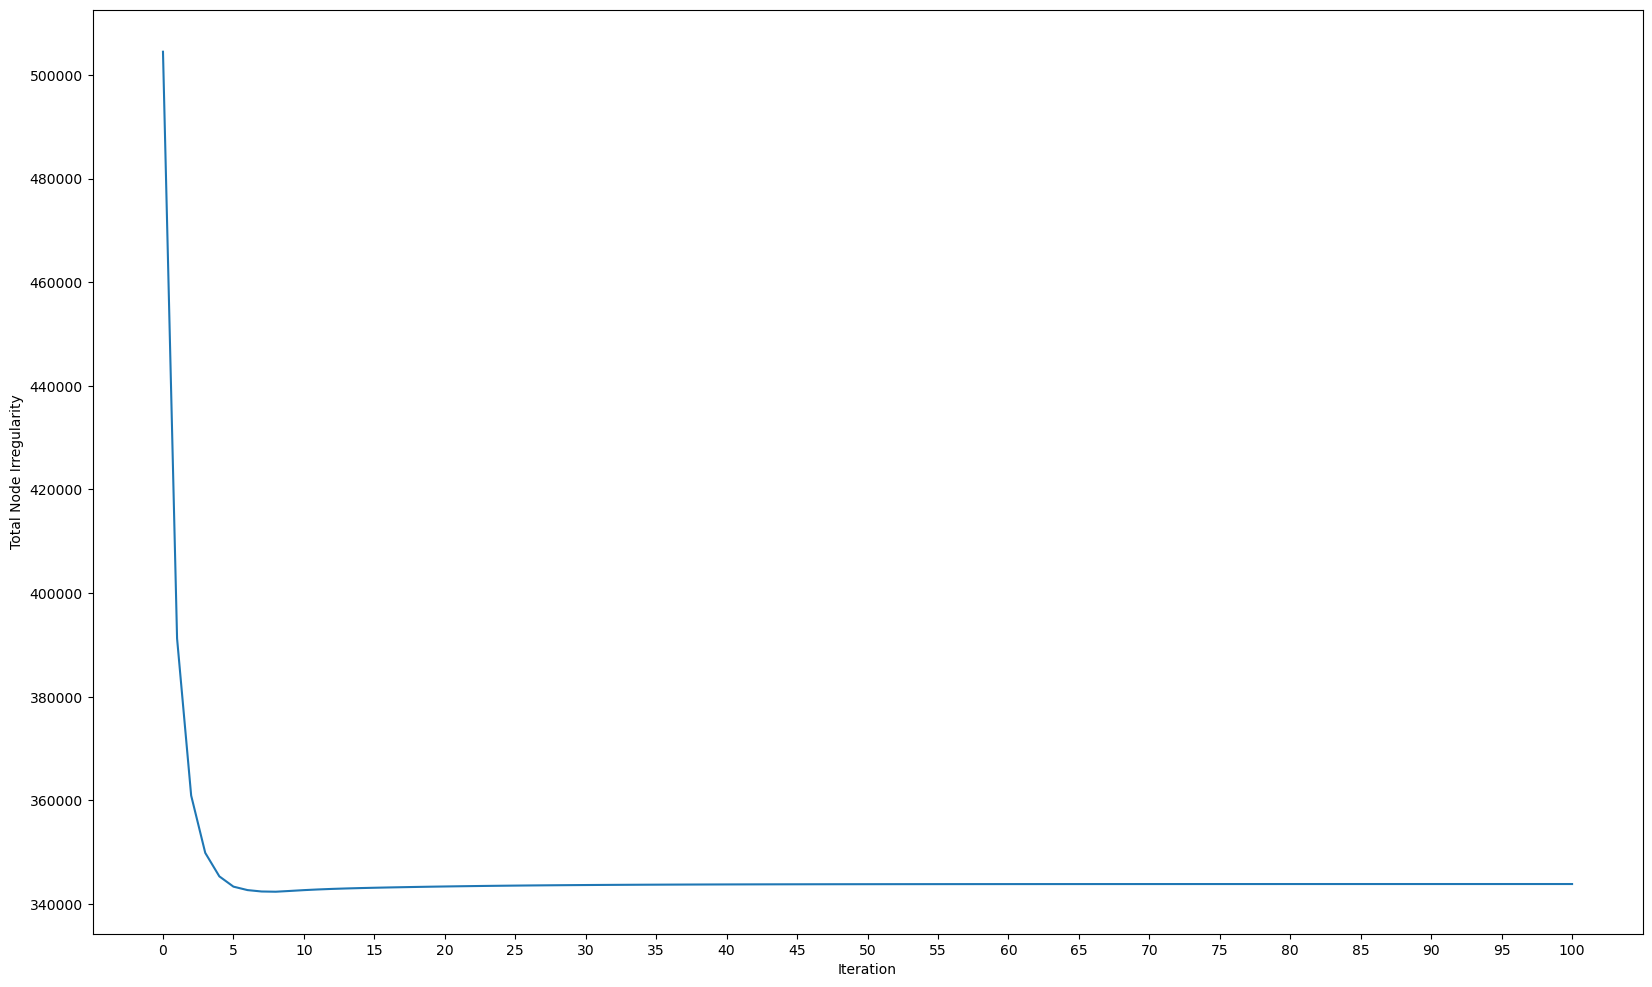

In [14]:

#plot the multipliers and the total node loss
plt.figure(figsize=(20, 12))
#plt.plot(range(len(mults)), mults)
plt.plot(range(len(losses)), losses)
#add labels
plt.xlabel('Iteration')
plt.ylabel('Total Node Irregularity')
#make the tick marks 5 iterations
plt.xticks(np.arange(0, len(losses), 5))
#plt.title('Total Node Irregularity vs Iteration')
plt.show()

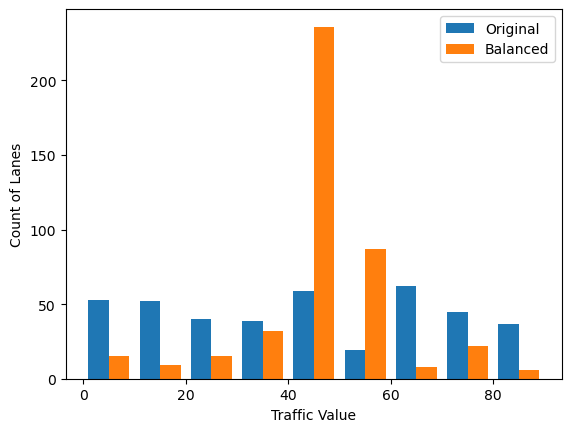

In [15]:
#compare the traffic distribution of the original graph and the balanced graph
#first, make a list of the traffic values of the edges of the original graph
traffic = [np.repeat(G.edges[edge]['traffic'], G.edges[edge]['lanes']) for edge in G.edges]
#then, make a list of the traffic values of the edges of the balanced graph
traffic2 = [np.repeat(G_la.edges[edge]['traffic'], G_la.edges[edge]['lanes']) for edge in G_la.edges]

traffic = np.concatenate(traffic)
traffic2 = np.concatenate(traffic2)

#now, make a histogram with both traffic distributions
plt.hist([traffic, traffic2], label = ['Original', 'Balanced'], bins=np.arange(0, 100, 10))
plt.xlabel('Traffic Value')
plt.ylabel('Count of Lanes')
#plt.title('Traffic Distribution')
plt.legend()
plt.show()

C:\Users\advay\AppData\Local\Temp\ipykernel_12884\3776034996.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(traffic, shade=True, label='Original')
C:\Users\advay\AppData\Local\Temp\ipykernel_12884\3776034996.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(traffic2, shade=True, label='Balanced')


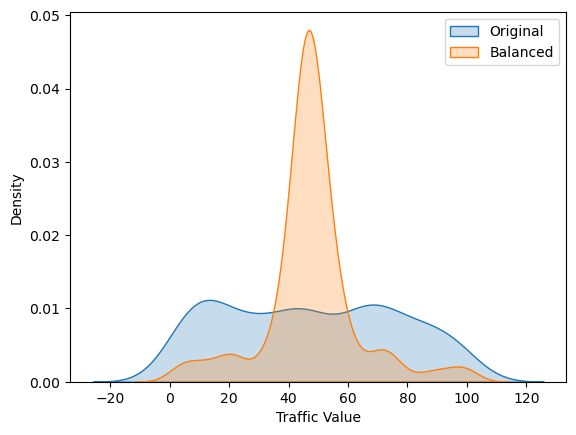

In [16]:
#desnity plot
sns.kdeplot(traffic, shade=True, label='Original')
sns.kdeplot(traffic2, shade=True, label='Balanced')
plt.xlabel('Traffic Value')
plt.ylabel('Density')
#plt.title('Traffic Distribution')
plt.legend()
plt.show()


In [17]:
#describe the traffic distribution of the original graph
print('Original graph')
print('Mean:', np.mean(traffic))
print('Median:', np.median(traffic))
print('Standard deviation:', np.std(traffic))
print('Min:', np.min(traffic))
print('Max:', np.max(traffic))

#describe the traffic distribution of the balanced graph
print('Balanced graph')
print('Mean:', np.mean(traffic2))
print('Median:', np.median(traffic2))
print('Standard deviation:', np.std(traffic2))
print('Min:', np.min(traffic2))
print('Max:', np.max(traffic2))


Original graph
Mean: 47.48868778280543
Median: 47.0
Standard deviation: 29.137699431189475
Min: 0.0
Max: 100.0
Balanced graph
Mean: 47.48868778280548
Median: 47.140673486590345
Standard deviation: 15.909290003632695
Min: 3.0
Max: 100.0


In [18]:
#Check the stats before and after
print("Original graph vs balanced graph")
print('Total node loss:', round(totalNodeLoss(G)), round(totalNodeLoss(G_la)), round(totalNodeLoss(G_la) / totalNodeLoss(G) * 100, 2), '%')
print('Total edge loss:', round(totalEdgeLoss(G)), round(totalEdgeLoss(G_la)), round(totalEdgeLoss(G_la) / totalEdgeLoss(G) * 100, 2), '%')
print('Total traffic:', round(totalTraffic(G)), round(totalTraffic(G_la)), round(totalTraffic(G_la) / totalTraffic(G) * 100, 2), '%')
#look at the sum of the border traffic
print('Total border traffic:', np.sum([G.nodes[node]['traffic'] for node in G.nodes if G.nodes[node]['border']]), np.sum([G_la.nodes[node]['traffic'] for node in G_la.nodes if G_la.nodes[node]['border']]), np.sum([G_la.nodes[node]['traffic'] for node in G_la.nodes if G_la.nodes[node]['border']]) / np.sum([G.nodes[node]['traffic'] for node in G.nodes if G.nodes[node]['border']]) * 100, '%')

Original graph vs balanced graph
Total node loss: 1054796 343878 32.6 %
Total edge loss: 573676 138924 24.22 %
Total traffic: 20990 20990 100.0 %
Total border traffic: 5178.0 5178.000000000133 100.00000000000256 %


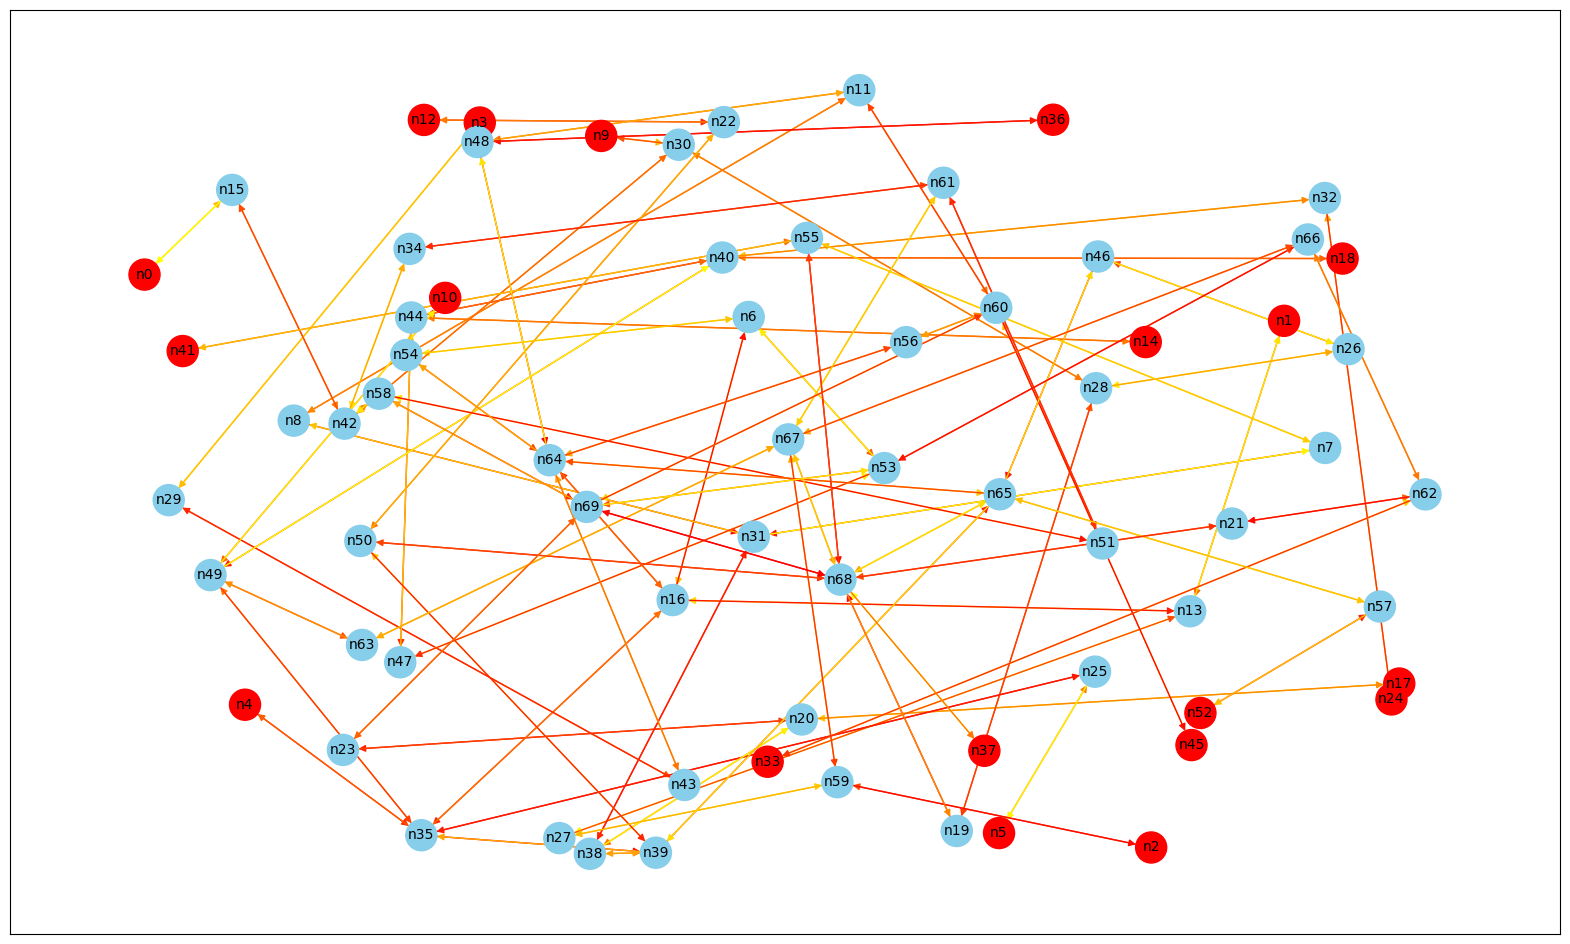

In [19]:
#plot the traffic distribution of the original graph
plt.figure(figsize=(20, 12))
nx.draw_networkx(G, with_labels=True, node_size=500, font_size=10, node_color=np.where(list(nx.get_node_attributes(G, 'border').values()), 'r', 'skyblue'), edge_color=[G.edges[edge]['traffic'] for edge in G.edges], edge_cmap=plt.cm.autumn, pos=pos)

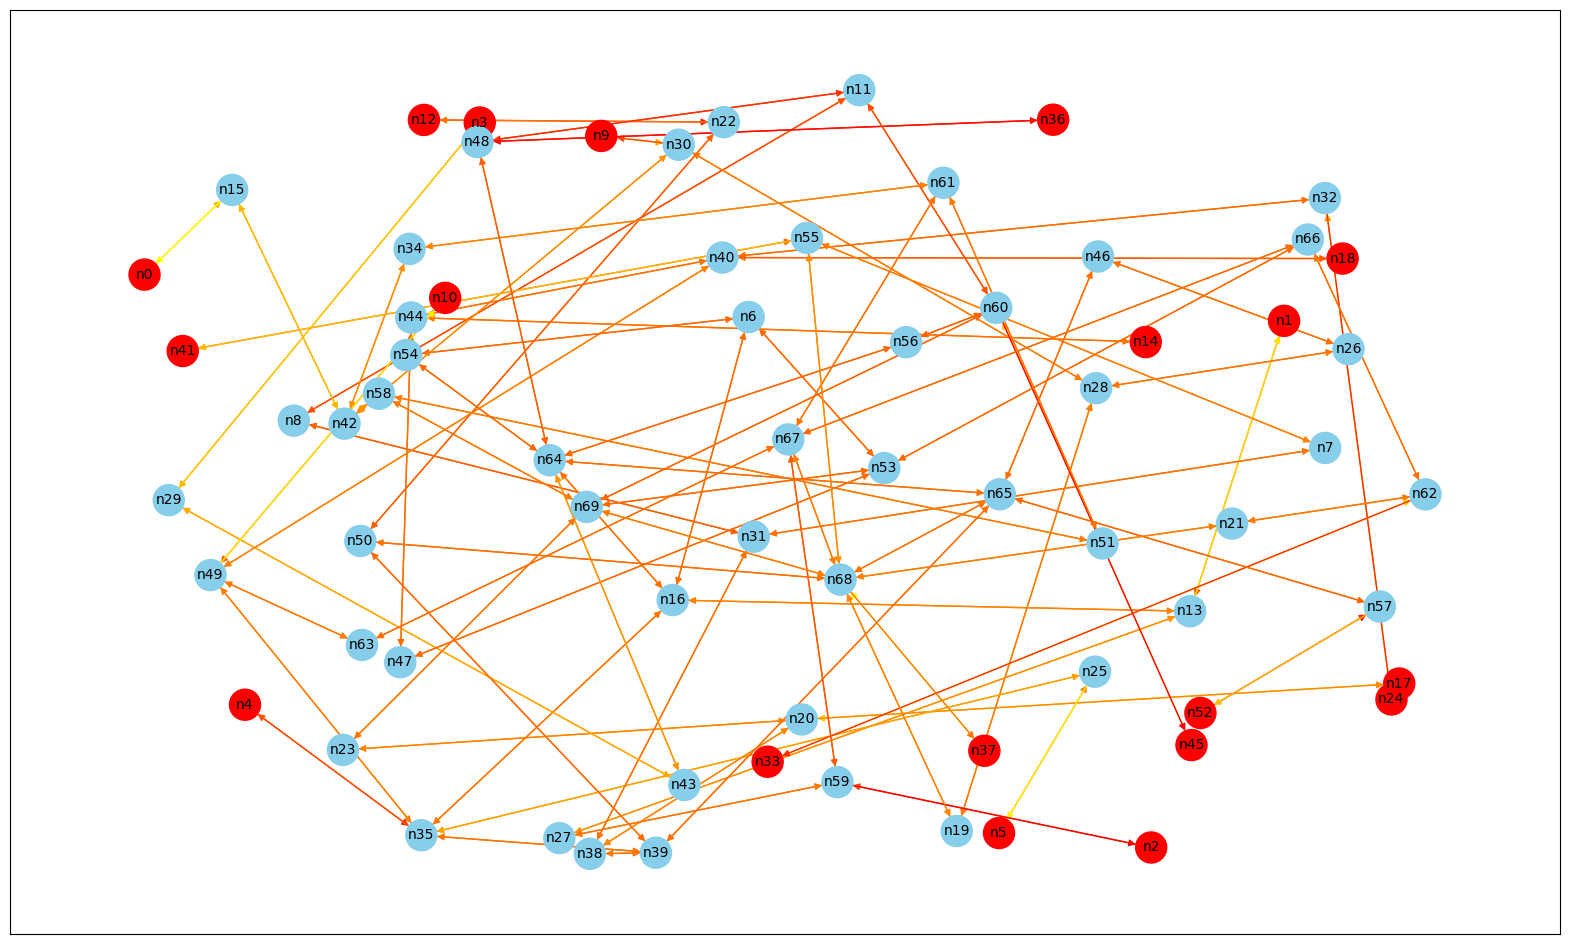

In [20]:
plt.figure(figsize=(20, 12))
nx.draw_networkx(G_la, with_labels=True, node_size=500, font_size=10, node_color=np.where(list(nx.get_node_attributes(G_la, 'border').values()), 'r', 'skyblue'), edge_color=[G_la.edges[edge]['traffic'] for edge in G_la.edges], edge_cmap=plt.cm.autumn, pos=pos)

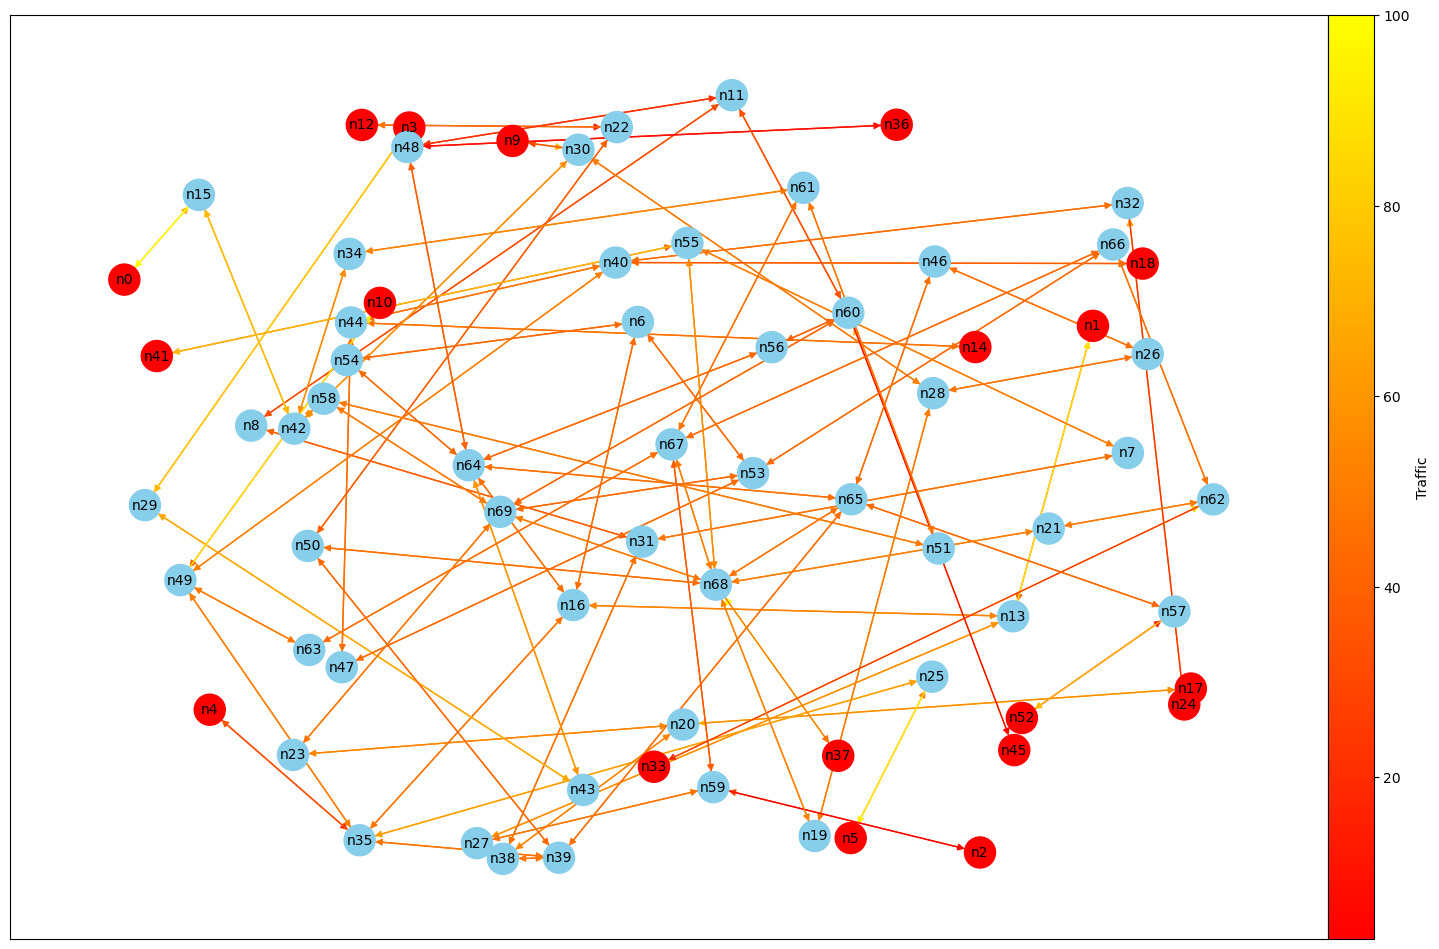

In [21]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Assuming you have already defined G and pos

# Draw the graph
plt.figure(figsize=(20, 12))
# Create a colormap that is the second half of the copper colormap
cmap = plt.cm.autumn
# Draw the network with node colors and edge colors
nx.draw_networkx(G_la, with_labels=True, node_size=500, font_size=10, node_color=np.where(list(nx.get_node_attributes(G, 'border').values()), 'r', 'skyblue'), edge_color=[G_la.edges[edge]['traffic'] for edge in G_la.edges], edge_cmap=cmap, pos=pos)

# Get the current Axes instance
ax = plt.gca()

# Create a ScalarMappable to map numerical values to colors in the colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min([G_la.edges[edge]['traffic'] for edge in G_la.edges]), vmax=max([G.edges[edge]['traffic'] for edge in G_la.edges])))

# Empty array to hold the values for the color bar
sm.set_array([])

# Add the color bar at the bottom of the plot
plt.colorbar(sm, ax=ax, label='Traffic', pad=-0, orientation='vertical')

# Show the plot
plt.show()
